# Centerline velocity plot

In [1]:
import numpy as np
import pandas as pd
import netCDF4 as ncf
import scipy
import tqdm
import matplotlib.pyplot as plt
import pickle

# Pick profile

In [2]:
profile = 'center'
#profile = 'valerie'

## Load points

In [3]:
match profile:
    case 'center' :
        points = pd.read_csv("./centerline_points_100m.csv")
    case 'valerie' :
        points = pd.read_csv("./valerie_100m.csv")
    case 'cross' :
        points = pd.read_csv("./cross_100m.csv")

In [4]:
# import data

# velocity
# import inverted velocities

fn = '/home/martin/projects/Hubbard2024/velocity/Hubbard_S1.nc'
data = ncf.Dataset(fn)
vx = np.array(data.variables['vx'][:])
vy = data.variables['vy'][:]
v = np.sqrt(vx**2+vy**2)
#v[v<=10]=np.nan
ts = data.variables['time'][:]
t = [int(ts[k]) for k in range(len(ts))]
# units: days since 2014-01-01

# datetime64 bounds and steps
t0 = np.datetime64("2014-01-01")
tsteps = t0+t

x = np.array(data.variables['x'][:])
y = np.array(data.variables['y'][:])

In [5]:
# Interpolate to daily velocities

speeds = np.zeros((len(tsteps), len(points)))
xi = points['X'].to_numpy()
yi = points['Y'].to_numpy()
from scipy.interpolate import RectBivariateSpline
for k in range(len(tsteps)):
    vi = RectBivariateSpline(y,x,np.squeeze(v[k,:,:]))
    for i in range(len(xi)):
        speeds[k,i]=vi(yi[i],xi[i])
speeds[speeds<=10]=np.nan

In [6]:
# Save speeds
#with open("speeds_centerline.pkl", mode="wb") as fd:
#    pickle.dump(speeds, fd)
    
match profile:
    case 'center':
        with open("speeds_centerline.pkl", mode="wb") as fd:
            pickle.dump(speeds, fd)
    case 'valerie':
        with open("valerie_centerline.pkl", mode="wb") as fd:
            pickle.dump(speeds, fd)

In [7]:
# Load speeds
match profile:
    case 'center':
        with open("speeds_centerline.pkl", mode="rb") as fd:
            speeds=pickle.load(fd)
    case 'valerie':
        with open("valerie_centerline.pkl", mode="rb") as fd:
            speeds=pickle.load(fd)

/tmp/ipykernel_102839/2695820821.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  clb.set_ticklabels(['0','2','4','6','8','10'],fontsize=18)


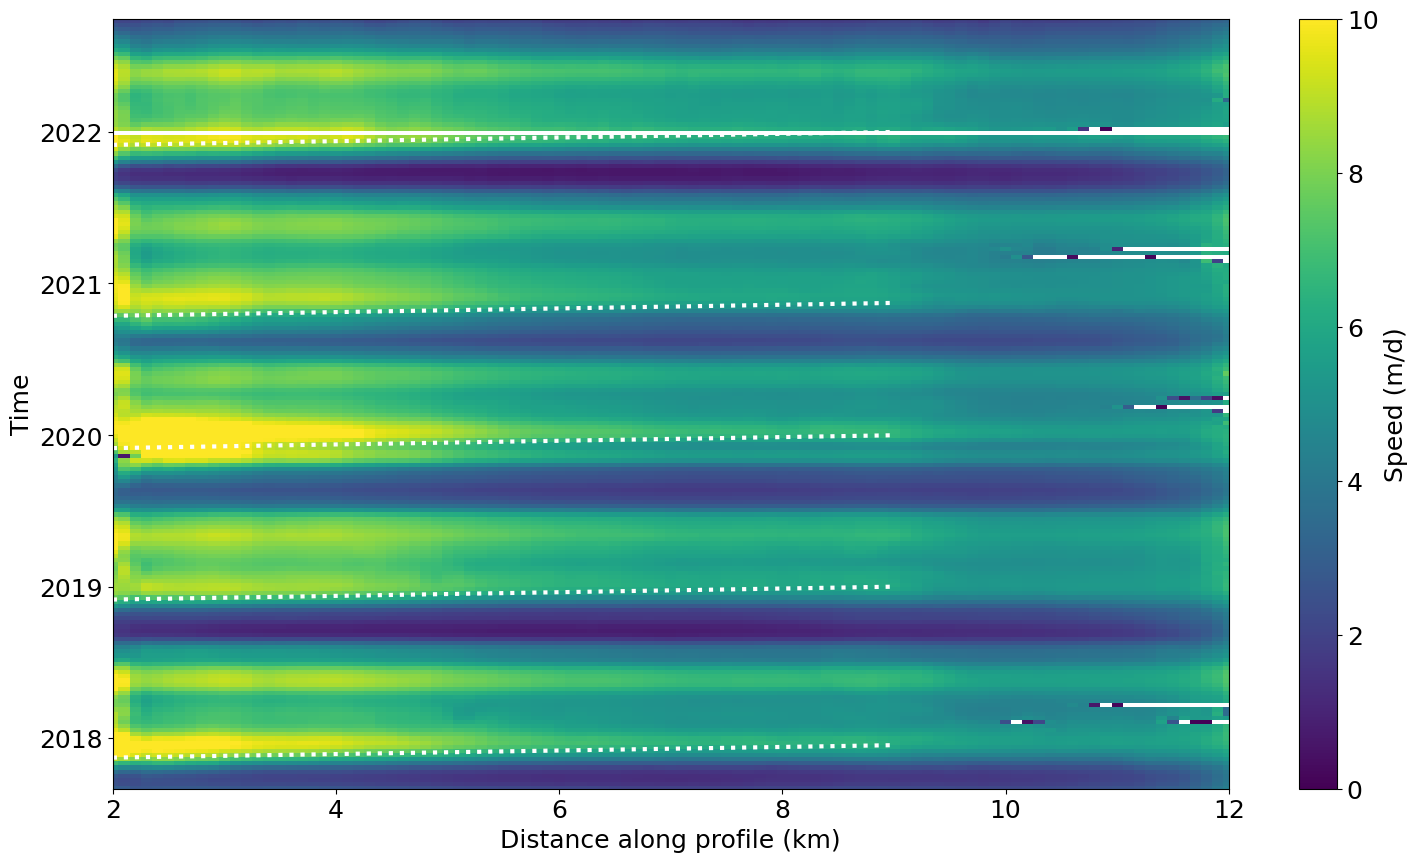

In [12]:
import seaborn as sns
# construct cmap
my_cmap = sns.color_palette("icefire", as_cmap=True)
my_cmap = 'viridis'
plt.figure(figsize=(18, 10))

match profile:
    case 'center':
        #plt.pcolormesh((np.arange(len(points)))/10, tsteps, np.fliplr(speeds)/365, cmap=my_cmap, vmin=0, vmax=12)
        plt.pcolormesh((np.arange(len(points)))/10, tsteps, speeds/365, cmap=my_cmap, vmin=0, vmax=10)

        plt.ylabel("Time", fontsize=18)
        plt.xlabel("Distance along profile (km)", fontsize=18)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        clb = plt.colorbar()
        clb.set_label("Speed (m/d)", fontsize=18)
        clb.set_ticklabels(['0','2','4','6','8','10'],fontsize=18)
        plt.ylim(np.datetime64("2017-09-01"), np.datetime64("2022-10-01"))
        plt.xlim(2, 12)
        #plt.xticks(np.arange(6,20,2),['0','2','4','6','8','10','12'])
        #plt.title("Hubbard speed vs distance")
        # guess propagation speeds, roughly 9 km / 1 month or 300 m/d
        plt.plot([2,9],[np.datetime64("2017-11-15"),np.datetime64("2017-12-15")], 'w:', linewidth=3)
        plt.plot([2,9],[np.datetime64("2018-12-01"),np.datetime64("2019-01-01")], 'w:', linewidth=3)
        plt.plot([2,9],[np.datetime64("2019-12-01"),np.datetime64("2020-01-01")], 'w:', linewidth=3)
        plt.plot([2,9],[np.datetime64("2020-10-15"),np.datetime64("2020-11-15")], 'w:', linewidth=3)
        plt.plot([2,9],[np.datetime64("2021-12-01"),np.datetime64("2022-01-01")], 'w:', linewidth=3)
        plt.savefig("centerline_speeds.png", bbox_inches="tight", dpi=300)
    
    case 'valerie':
        plt.pcolormesh(np.arange(len(points))/10, tsteps, speeds, cmap=my_cmap, vmin=0, vmax=3000)

        plt.ylabel("Time", fontsize=18)
        plt.xlabel("Distance along profile (km)")
        plt.colorbar(label="Speed (m/yr)")
        plt.ylim(np.datetime64("2016-09-01"), np.datetime64("2022-10-01"))
        plt.title("Valerie speed vs distance")
        plt.savefig("valerie_speeds.png", bbox_inches="tight", dpi=300)

(array([17167., 17532., 17897., 18262., 18628., 18993.]),
 [Text(0, 17167.0, '2017'),
  Text(0, 17532.0, '2018'),
  Text(0, 17897.0, '2019'),
  Text(0, 18262.0, '2020'),
  Text(0, 18628.0, '2021'),
  Text(0, 18993.0, '2022')])

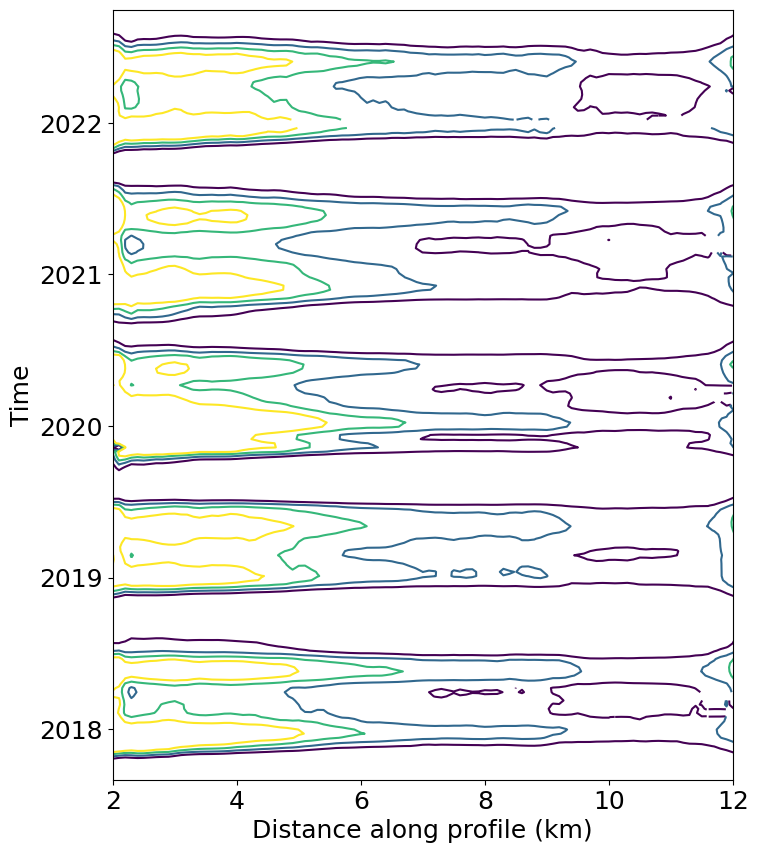

In [9]:
plt.figure(figsize=(8, 10))
plt.contour((np.arange(len(points)))/10, tsteps, speeds/365, [5,6,7,8])
plt.ylim(np.datetime64("2017-09-01"), np.datetime64("2022-10-01"))
plt.xlim(2, 12)
plt.ylabel("Time", fontsize=18)
plt.xlabel("Distance along profile (km)", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

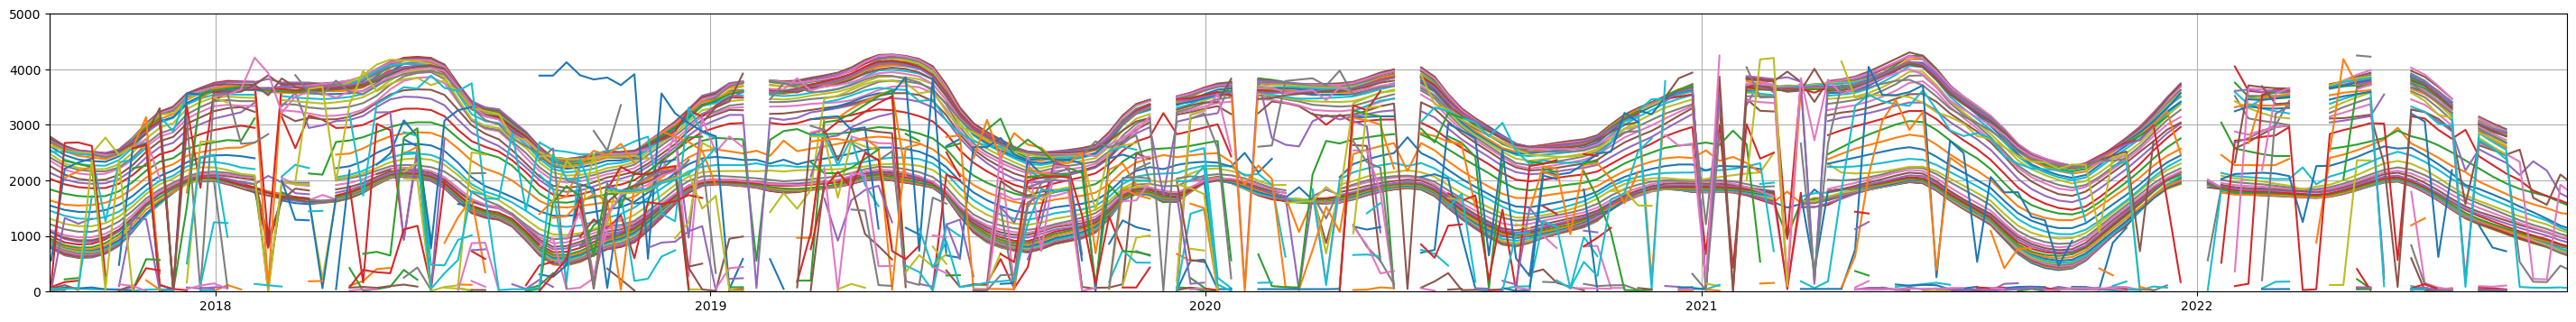

In [14]:
speeds_culled=speeds
speeds_culled[np.abs(speeds)>5000] =  np.nan
speeds_culled[speeds<0] =  np.nan

plt.figure(figsize=(36,4))
plt.plot(tsteps,speeds_culled[:,100:170])
#plt.plot(tsteps,speeds_culled[:,125])

#plt.plot(tsteps,speeds_culled[:,170]-speeds_culled[:,125])
plt.ylim([0,5000])
plt.xlim(np.datetime64("2017-09-01"), np.datetime64("2022-10-01"))
plt.grid()
plt.savefig('test.png', dpi=600)
#plt.pcolormesh(speeds_culled)
#plt.colorbar()
#np.shape(speeds)

In [26]:
def plt_timeslice(k):
    plt.figure(figsize=(9,9))
    v_slice =  np.squeeze(v[k,:,:])
    vx_slice =  np.squeeze(vx[k,:,:])
    vy_slice =  np.squeeze(vy[k,:,:])
    plt.pcolormesh(x,y,v_slice, vmax=3000)
    plt.quiver(x[::5],y[::5],vx_slice[::5,::5], vy_slice[::5,::5],scale=5e4)
    plt.axis('equal')
    plt.ylim([250000,265000])
    plt.xlim([-3.315e6, -3.303e6])
    plt.axis('off')
    plt.text(-3.302e6,251500,tsteps[k], rotation=270, fontsize=20)
    plt.savefig('./timeslices/velfield_'+str(k)+'.png')
    plt.close("all")
    return

plt_timeslice(k)
#for k in range(len(tsteps)):
#    plt_timeslice(k)

(-3315000.0, -3303000.0, 250000.0, 265000.0)

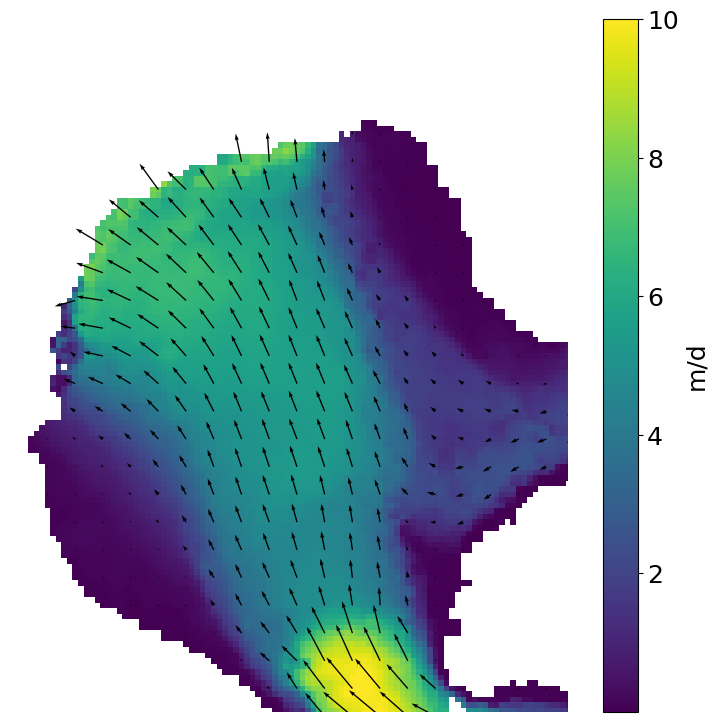

In [39]:
k=200

plt.figure(figsize=(9,9))
v_slice =  np.squeeze(v[k,:,:])
vx_slice =  np.squeeze(vx[k,:,:])
vy_slice =  np.squeeze(vy[k,:,:])
plt.pcolormesh(x,y,v_slice/365, vmax=10)
cbar = plt.colorbar()
cbar.set_label('m/d', fontsize=18)
cbar.ax.tick_params(labelsize=18) 
plt.quiver(x[::5],y[::5],vx_slice[::5,::5], vy_slice[::5,::5],scale=5e4)
plt.axis('equal')
plt.ylim([250000,265000])
plt.xlim([-3.315e6, -3.303e6])
plt.axis('off')

TypeError: only integer scalar arrays can be converted to a scalar index

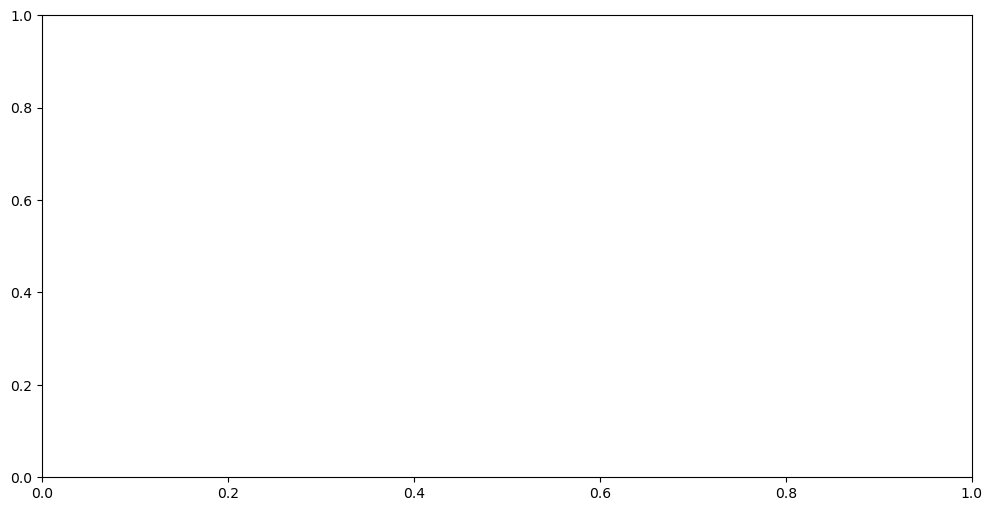

In [11]:


colors = sns.color_palette('hls', 5)
clrs = [c for c in colors for _ in (0, 1)]
fig, ax = plt.subplots(figsize=(12,6))
ax.set_prop_cycle('color', clrs)

# find the position of the first maximum
offset = 30 # check for maximum within 'offset' days of Jan 1
x = np.arange(3500,0,-100)  # distance from terminus, points are in 100 m increments
for yr in range(2018,2023):
    I = np.squeeze(np.where(tsteps==np.datetime64(str(yr))))
    max_pos = np.argmax(speeds[I-offset:I+offset,:],axis=0)
    p=np.polyfit(x,max_pos[140:175],1)
    plt.plot(x, p[0]*x+p[1]-offset,':')
    pl=plt.plot(x, max_pos[140:175]-offset, label=str(yr))
    plt.text(3200,max_pos[140]-offset+2, '{:0.0f}'.format(1/p[0])+'m/d', color=pl[0].get_color(), fontweight='bold', fontsize=14)
plt.legend(loc='upper left')
plt.xlabel('Distance from Terminus (m)')
plt.ylabel('Time of peak velocity relative to Jan 1')
plt.savefig('peak1_propagation.png')

TypeError: only integer scalar arrays can be converted to a scalar index

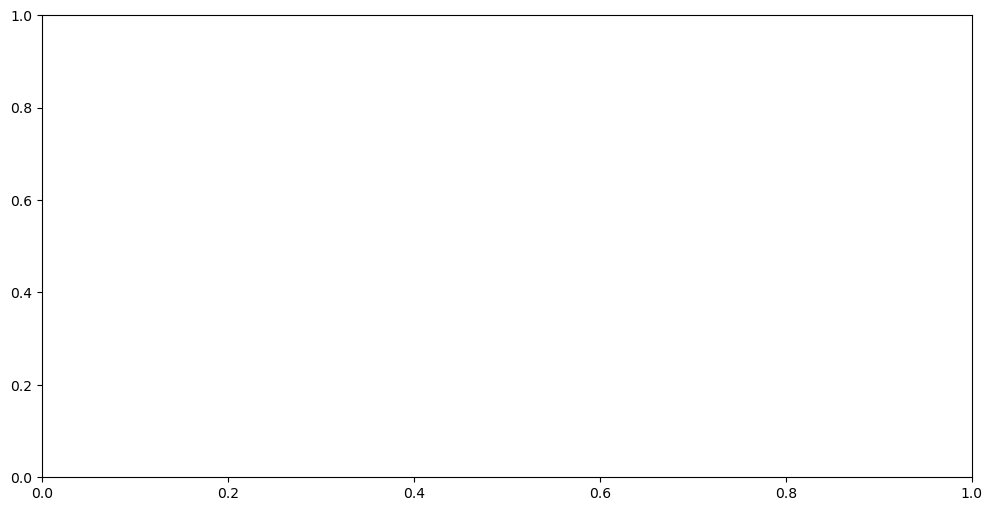

In [12]:
# find the position of the second maximum

colors = sns.color_palette('hls', 5)
clrs = [c for c in colors for _ in (0, 1)]
fig, ax = plt.subplots(figsize=(12,6))
ax.set_prop_cycle('color', clrs)

offset = 40 # check for maximum within 'offset' days of Jan 1
x = np.arange(3500,0,-100)  # distance from terminus, points are in 100 m increments
for yr in range(2018,2023):
    I = np.squeeze(np.where(tsteps==np.datetime64(str(yr)+'-05-01')))
    max_pos = np.argmax(speeds[I-offset:I+offset,:],axis=0)
    p=np.polyfit(x,max_pos[140:175],1)
    plt.plot(x, p[0]*x+p[1]-offset,':')
    pl=plt.plot(x, max_pos[140:175]-offset, label=str(yr))
    plt.text(3200,max_pos[140]-offset+2, '{:0.0f}'.format(1/p[0])+'m/d', color=pl[0].get_color(), fontweight='bold', fontsize=14)
plt.legend(loc='upper left')
plt.xlabel('Distance from Terminus (m)')
plt.ylabel('Time of peak velocity relative to Jan 1')
plt.savefig('peak2_propagation.png')

In [13]:
from rasterio.plot import show
import rasterio as rio
from rasterio.enums import Resampling
from pyproj import Transformer

In [14]:
def pct_clip(array,pct=[2,98]):
    array_min, array_max = np.nanpercentile(array,pct[0]), np.nanpercentile(array,pct[1])
    clip = (array - array_min) / (array_max - array_min)
    clip[clip>1]=1
    clip[clip<0]=0
    return clip

with rio.open('/home/martin/projects/Hubbard2024/images/Planet_Hubbard.tif') as src:
    with rio.open(
            'RGB_Temp.tif', 'w+',
            driver='GTiff',
            dtype= rio.float32,
            count=3,
            crs = src.crs,
            width=src.width,
            height=src.height,
            transform=src.transform,
        ) as dst:
        V = pct_clip(src.read(1))
        dst.write(V,1)
        V = pct_clip(src.read(2))
        dst.write(V,2)
        V = pct_clip(src.read(3))
        dst.write(V,3)
    

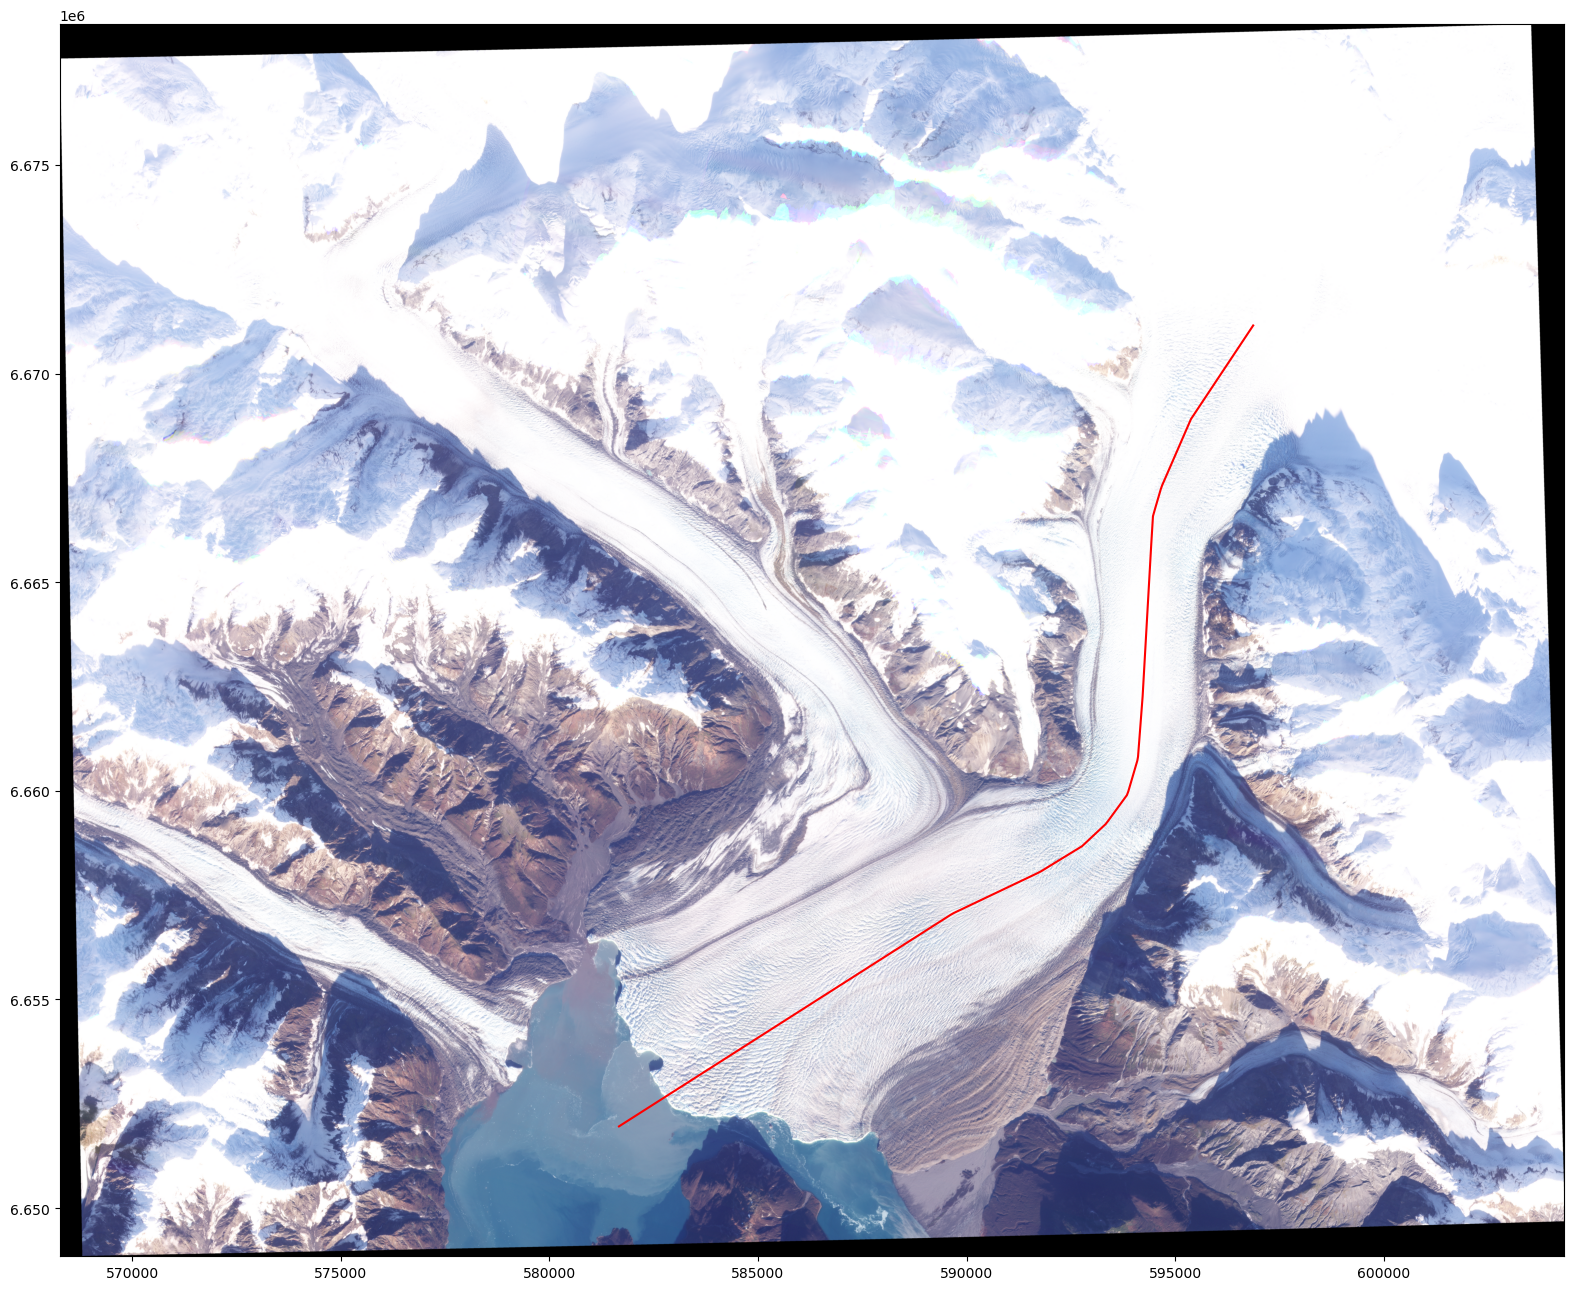

In [47]:
fig,ax=plt.subplots(figsize=(20,16))
with rio.open("RGB_Temp.tif") as src2:
    show(src2.read(),transform=src2.transform,ax=ax)
    
transformer = Transformer.from_crs("epsg:3413", "epsg:32607") # UTM 6N
x, y = transformer.transform(points.X.to_numpy(),points.Y.to_numpy())
ax.plot(x,y,'r')
plt.savefig('map.png')

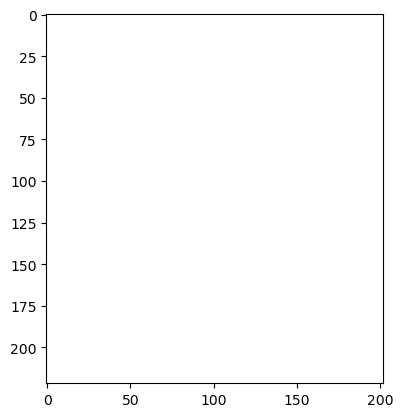

In [37]:
plt.imshow(v[10,:,:])

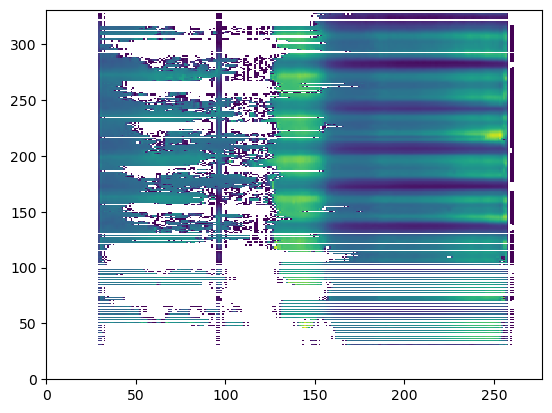

In [77]:
plt.pcolormesh(np.fliplr(speeds))

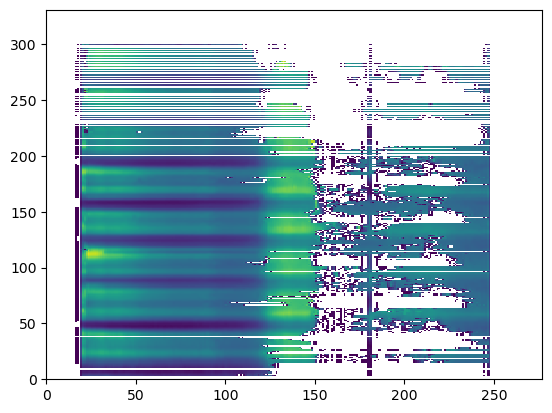

In [76]:
plt.pcolormesh(np.flipud(speeds))